In [2]:
import warnings, os
warnings.filterwarnings("ignore")


import pandas as pd
import numpy as np

from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_auc_score
from sklearn.metrics import auc as calculate_auc

import matplotlib.pyplot as plt
import seaborn as sns

from aggmap import AggMap, AggModel

np.random.seed(666) #just for reaptable results

def prc_auc_score(y_true, y_score):
    precision, recall, threshold  = precision_recall_curve(y_true, y_score) #PRC_AUC
    auc = calculate_auc(recall, precision)
    return auc

In [3]:
dfx = pd.read_excel('./CRC.xlsx', sheet_name='data')
dfx = dfx[dfx.columns[1:]]
dfx = np.log(dfx + 1e-8)

feature_groups_df = pd.read_excel('./CRC.xlsx', sheet_name='feature_info')
feature_group_list = feature_groups_df.Group.tolist()

dfy_all = pd.read_excel('./CRC.xlsx', sheet_name='sample_info')
dfy = pd.get_dummies(dfy_all['Group'])



X = dfx.values.astype(float)
Y = dfy.values.astype(float)


In [4]:
model_save_path = './model'
if not os.path.exists(model_save_path):
    os.makedirs(model_save_path)

In [5]:
mp = AggMap(dfx, metric = 'correlation')
mp.fit(cluster_channels = 5, verbose = 0)

mp.save(os.path.join(model_save_path, 'aggmap.mp'))

2020-10-14 19:09:10,945 - INFO - [bidd-aggmap] - Calculating distance ...
2020-10-14 19:09:10,990 - INFO - [bidd-aggmap] - the number of process is 16


100%|##########| 849/849 [00:01<00:00, 775.73it/s]


2020-10-14 19:09:25,529 - INFO - [bidd-aggmap] - applying hierarchical clustering to obtain group information ...
2020-10-14 19:09:30,579 - INFO - [bidd-aggmap] - Applying grid feature map(assignment), this may take several minutes(1~30 min)
2020-10-14 19:09:32,040 - INFO - [bidd-aggmap] - Finished


['./model/aggmap.mp']

## Leave One Study Out: LOSO

In [6]:
country_idx = dfy_all.groupby(['Country']).apply(lambda x:x.index.tolist())
country_idx

Country
AUS    [114, 115, 116, 117, 118, 119, 120, 121, 122, ...
CHI    [223, 224, 225, 226, 227, 228, 229, 230, 231, ...
FRA    [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...
GER    [455, 456, 457, 458, 459, 460, 461, 462, 463, ...
USA    [351, 352, 353, 354, 355, 356, 357, 358, 359, ...
dtype: object

In [7]:
country_names = country_idx.index.tolist()

In [94]:
# LOSO

from itertools import chain

run_all= []
for test_country in country_names:
    
    test_idx = country_idx.loc[test_country]
    train_idxs = country_idx[country_idx.index !=test_country].tolist()
    #print(train_idxs)
    train_idx = list(chain(*train_idxs))
    #print(train_idx)

    print(len(train_idx), len(test_idx)) 
    
    trainx = X[train_idx]
    trainY = Y[train_idx]
    
    testY = Y[test_idx]
    testx = X[test_idx]
    
    trainX = mp.batch_transform(trainx, scale_method = 'standard')
    testX = mp.batch_transform(testx, scale_method = 'standard')  

    clf = AggModel.MultiClassEstimator(epochs = 30, conv1_kernel_size = 5, batch_size = 1, gpuid = 2, verbose = 0)
    clf.fit(trainX, trainY)    
    
    y_true = testY[:,0]
    y_pred = clf.predict(testX)[:,0]
    y_score = clf.predict_proba(testX)[:,0] ##对test_x进行预测，返回值为array数组，其中每行都代表一个样本，第一个值表示预测为0的概率，第二个值表示预测为1的概率，并且每行的概率值之和都为1。

    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    acc = (tp + tn) / sum([tn, fp, fn, tp])

    sensitivity = tp / sum([tp, fn])
    specificity = tn / sum([tn, fp])

    prc_auc = prc_auc_score(y_true, y_score)
    roc_auc = roc_auc_score(y_true, y_score)

    precision = tp / sum([tp, fp])
    recall =  tp / sum([tp, fn]) #equals to sensitivity


    res = {#'train_country': train_country,
            'test_country':test_country,
            'accuracy':acc, 
            'prc_auc':prc_auc, 
            'roc_auc':roc_auc,
            'sensitivity': sensitivity, 
            'specificity': specificity,
            'precision':precision,
            'recall':recall,
              }
    run_all.append(res)    

  0%|          | 0/466 [00:00<?, ?it/s]

466 109


100%|##########| 109/109 [00:00<00:00, 532.17it/s]


MultiClassEstimator(batch_size=1, conv1_kernel_size=5, epochs=30, gpuid='2')


 11%|#         | 48/447 [00:00<00:00, 444.90it/s]

447 128


100%|##########| 128/128 [00:00<00:00, 581.04it/s]


MultiClassEstimator(batch_size=1, conv1_kernel_size=5, epochs=30, gpuid='2')


  9%|8         | 40/461 [00:00<00:01, 325.10it/s]

461 114


100%|##########| 114/114 [00:00<00:00, 521.01it/s]


MultiClassEstimator(batch_size=1, conv1_kernel_size=5, epochs=30, gpuid='2')


  9%|8         | 40/455 [00:00<00:01, 307.27it/s]

455 120


100%|##########| 120/120 [00:00<00:00, 565.92it/s]


MultiClassEstimator(batch_size=1, conv1_kernel_size=5, epochs=30, gpuid='2')


  8%|8         | 40/471 [00:00<00:01, 349.91it/s]

471 104


100%|##########| 104/104 [00:00<00:00, 539.54it/s]


MultiClassEstimator(batch_size=1, conv1_kernel_size=5, epochs=30, gpuid='2')


In [95]:
clf._model.count_params()

300098

In [96]:
df = pd.DataFrame(run_all)
df.to_csv('./run_all_LOSO.csv')
df

,test_country,accuracy,prc_auc,roc_auc,sensitivity,specificity,precision,recall
0,AUS,0.844037,0.917441,0.920635,0.739130,0.920635,0.871795,0.739130
1,CHI,0.765625,0.886529,0.851727,0.729730,0.814815,0.843750,0.729730
2,FRA,0.710526,0.853104,0.838849,0.792453,0.639344,0.656250,0.792453
3,GER,0.850000,0.922430,0.910278,0.766667,0.933333,0.920000,0.766667
4,USA,0.682692,0.786532,0.726701,0.557692,0.807692,0.743590,0.557692


In [97]:
dfres = pd.crosstab(index = 'roc_auc', columns= df.test_country, values= df.roc_auc, aggfunc = np.mean)
dfres.to_excel('./LOSO_results_ROC.xlsx')

In [98]:
dfres.T

row_0,roc_auc
test_country,
AUS,0.920635
CHI,0.851727
FRA,0.838849
GER,0.910278
USA,0.726701


In [99]:
def get_non_diag_mean(df):
    v = df.values.copy()
    np.fill_diagonal(v, np.nan)
    mean =  pd.DataFrame(v, columns = df.columns, index = df.index).mean(axis=1).round(2)
    std = pd.DataFrame(v, columns = df.columns, index = df.index).std(axis=1).round(2)
    return mean,std

In [100]:
study2study_df = pd.read_excel('./study2study_results_ROC.xlsx', index_col='train_country')

In [101]:
get_non_diag_mean(study2study_df)[0].to_frame(name = 'AggMap-study2study')

,AggMap-study2study
train_country,
AUS,0.79
CHI,0.82
FRA,0.86
GER,0.83
USA,0.78


In [102]:
y_previous =  {"AUS":0.85,"CHI": 0.84, "FRA":0.82, "GER":0.90, "USA": 0.70}

In [103]:
order = ['FRA', 'AUS', 'CHI', 'USA', 'GER']

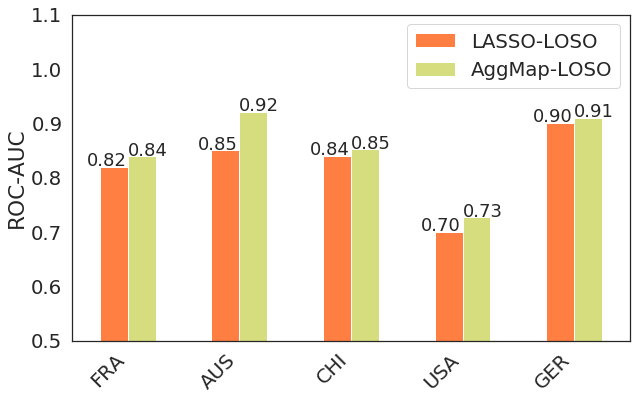

In [104]:
sns.set(style = 'white', font_scale=1.8)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,6), sharex = True, sharey = True)

y1 = pd.Series(y_previous).to_frame(name = 'LASSO-LOSO')
y2 = dfres.T['roc_auc'].to_frame(name = 'AggMap-LOSO')

#y1_err = get_non_diag_mean(study2study_df)[1].to_frame(name = 'AggMap-study2study')
#y2_err = get_non_diag_mean(ourmodel_df)[1].to_frame(name = 'AggMap-LOSO')

y = y1.join(y2)
#y_err = y1_err #.join(y2_err)

y = y.loc[order]
#y_err = y_err.loc[order]

color = sns.color_palette("rainbow_r", 5) #PiYG

y.plot(kind = 'bar',ax = ax, color = color, ylim = (0.5, 0.96), error_kw=dict(ecolor='gray', lw=2, capsize=6, capthick=2))
ax.set_ylabel('ROC-AUC')
ax.set_xlabel('')
ax.set_ylim(0.5,1.1)

for x_, y_ in enumerate(y['LASSO-LOSO'].values):
    ax.annotate('%.2f' % y_, xy = (x_-0.37, y_+0.002), fontsize =18)

for  x_, y_ in enumerate(y['AggMap-LOSO'].values):
    ax.annotate('%.2f' % y_, xy = (x_, y_+0.002), fontsize =18)
    
ax.set_xticklabels(labels = y.index,rotation=45, ha = 'right')

fig.savefig('./loso_aggmap_vs_lasso.png', bbox_inches='tight', dpi=400) 